In [1]:
import glob
import os
import geopandas as gpd
import pandas as pd
import contextily as ctx

from multiprocessing import Pool
from functools import partial

import plotnine
from plotnine import *

/tmp/ipykernel_19193/2241930480.py:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
OUTDIR = '/projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips'
ZONAL_DIR = '/projects/my-public-bucket/databank/boreal_height_cmip6/output/zonal_stats'

In [3]:
INDEX_FN = '/projects/shared-buckets/montesano/databank/boreal_height_cmip6/hydrobasins_L08_patterns_tte_boreal_tundra_3995.gpkg'
HYBAS_ID_LIST = gpd.read_file(INDEX_FN).HYBAS_ID.to_list()

In [4]:
LIST_GPKG_DONE = gpd.read_file('/projects/my-public-bucket/databank/boreal_height_cmip6/output/hydrobasins_L08_patterns_tte_boreal_tundra_3995_tcc_trends_part1.gpkg').HYBAS_ID.to_list()

In [5]:
# Get missing
LIST_HYBAS_ID_COG_FINISHED= [int(os.path.basename(f).split('_')[2]) for f in glob.glob(OUTDIR + '/*cog.tif' )]
print(f'{len(LIST_HYBAS_ID_COG_FINISHED)} basin clip cogs that have been processed.')

LIST_HYBAS_ID_COG_MISSING = [id for id in HYBAS_ID_LIST if id not in LIST_HYBAS_ID_COG_FINISHED]
print(f'{len(LIST_HYBAS_ID_COG_MISSING)} basin clip cogs still missing')

LIST_HYBAS_ID_GPKG_FINISHED= [int(os.path.basename(f).split('_')[2]) for f in glob.glob(ZONAL_DIR + '/*cog_zonalstats.gpkg' )] + LIST_GPKG_DONE
                            
print(f'{len(LIST_HYBAS_ID_GPKG_FINISHED)} zonal GPKGs that have been processed.')

LIST_HYBAS_ID_GPKG_MISSING = [id for id in LIST_HYBAS_ID_COG_FINISHED if id not in LIST_HYBAS_ID_GPKG_FINISHED]
print(f'{len(LIST_HYBAS_ID_GPKG_MISSING)} zonal GPKGs available to process ')

15068 basin clip cogs that have been processed.
1984 basin clip cogs still missing
9105 zonal GPKGs that have been processed.
5963 zonal GPKGs available to process 


In [6]:
HYBAS_ID_LIST[1]

8080000062

In [7]:
ZONAL_DIR = '/projects/my-public-bucket/databank/boreal_height_cmip6/output/zonal_stats'


In [8]:
z = glob.glob(ZONAL_DIR + '/*cog_zonalstats.gpkg')
len(z)

5081

In [9]:
for f in glob.glob(ZONAL_DIR + '/*cog_zonalstats.gpkg'):
    if os.path.getsize(f) < 1:
        print(f)
        os.remove(f)

In [ ]:
%%time
if False:
    zonal_smry_gdf = pd.concat([gpd.read_file(f) for f in glob.glob(ZONAL_DIR + '/*cog_zonalstats.gpkg')])
else:
    with Pool(processes=25) as pool:
        gdf_list = pool.map(partial(gpd.read_file), glob.glob(ZONAL_DIR + '/*cog_zonalstats.gpkg'))
    zonal_smry_gdf = pd.concat(gdf_list)  

In [ ]:
zonal_smry_gdf.info()

In [ ]:
zonal_smry_gdf.to_file(os.path.dirname(OUTDIR) + '/' + 'hydrobasins_L08_patterns_tte_boreal_tundra_3995_tcc_trends_part2.gpkg')

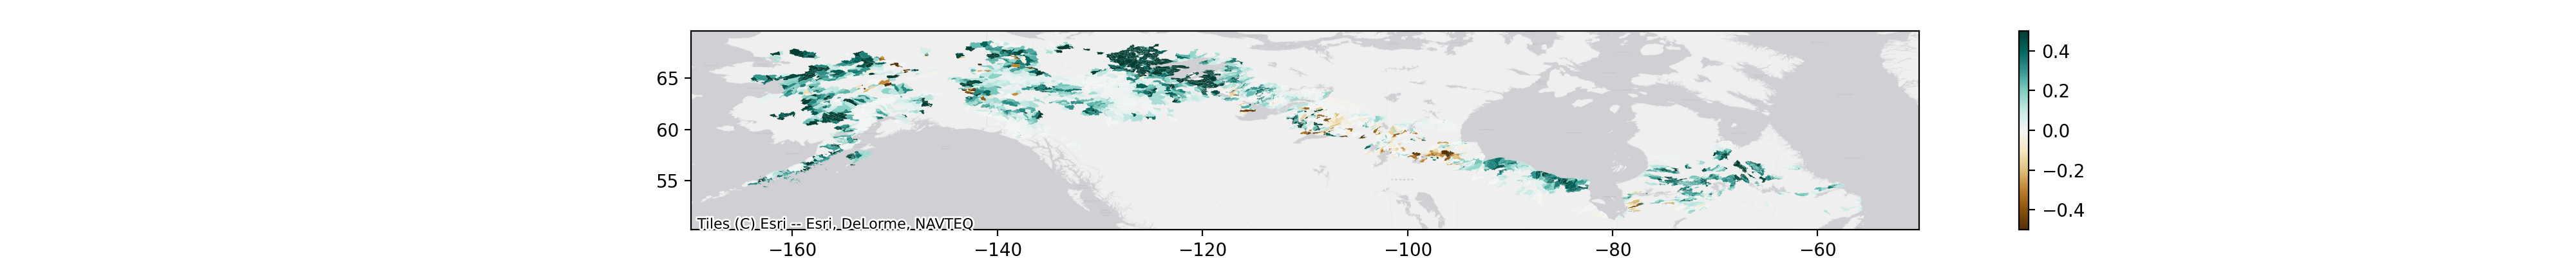

In [37]:
ax = zonal_smry_gdf.to_crs(4326).plot(column='val_terrapulse_tcc_slope_median', cmap='BrBG', legend=True, vmin=-0.5, vmax=0.5, figsize=(20,2))
ax = ctx.add_basemap(ax=ax, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas)

/opt/conda/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 445 rows containing non-finite values.


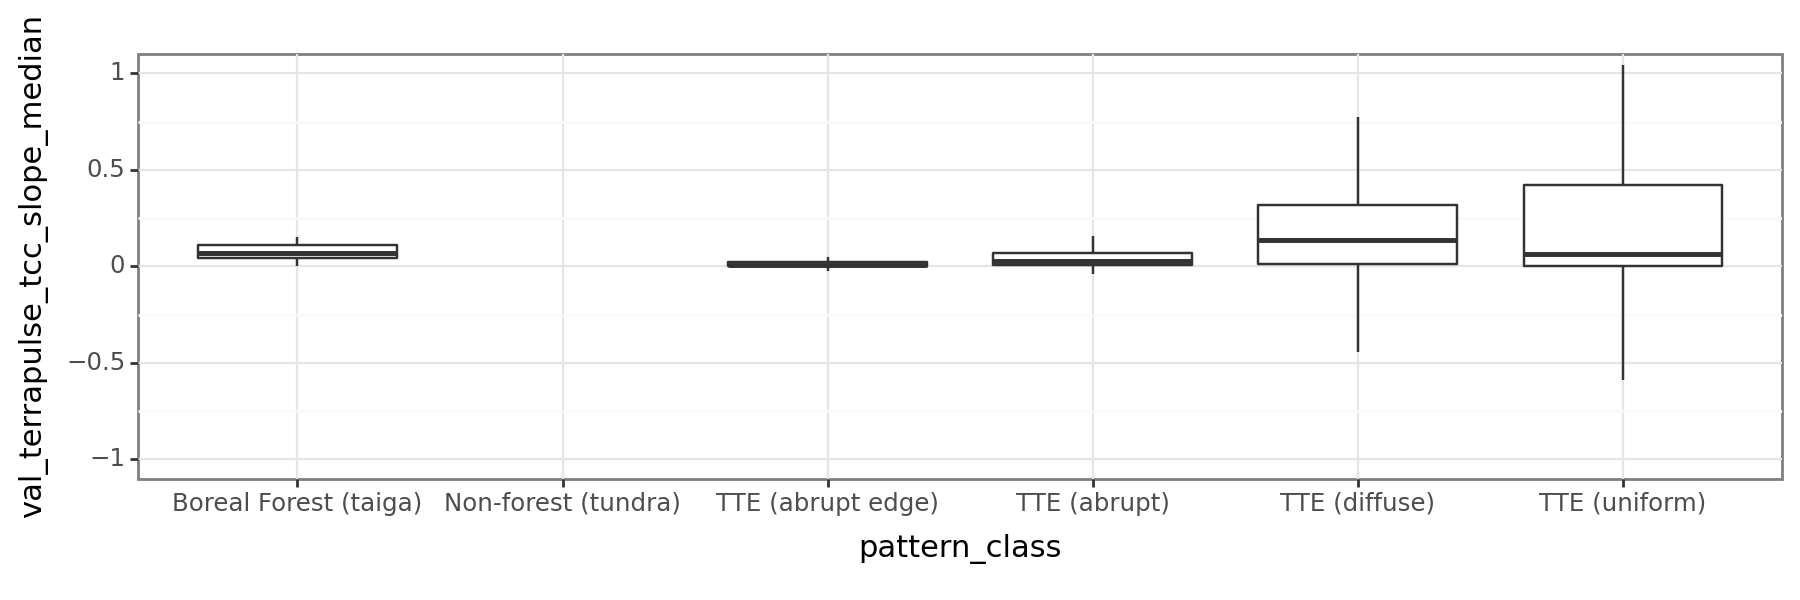

<Figure Size: (900 x 300)>

In [44]:
(
    ggplot(zonal_smry_gdf)
    + geom_boxplot(aes(x='pattern_class', y='val_terrapulse_tcc_slope_median', fill='val_terrapulse_tcc_slope_count'), outlier_shape = '')
    + theme_bw()
    + coord_cartesian(ylim=(-1,1))
    + theme(figure_size=(9,3))
)